In [ ]:
!pip install --upgrade pip

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


# Step 1: Environment Setup & Basic K-means

**Objective:** Set up Apache Spark and scikit-learn environments and run a basic K-means clustering to verify everything works.

**Environment:**
- Python 3.12.2
- Virtual environment (`venv`)
- Packages: `pyspark`, `scikit-learn`, `matplotlib`, `pandas`, `seaborn`, `jupyter`

In [3]:
pip install pyspark scikit-learn matplotlib pandas seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 MB 13.6 MB/s  0:00:33:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-an

In [30]:
# Setup
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris, load_wine, fetch_openml, make_blobs, fetch_kddcup99
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler as SparkScaler, VectorAssembler, StringIndexer, OneHotEncoder as SparkOneHotEncoder
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("BigDataPrep").getOrCreate()


25/11/30 01:33:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [10]:
# 1️⃣ Check Python environment and packages
import sys
import pyspark
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import pandas

print("Python version:", sys.version)
print("PySpark version:", pyspark.__version__)
print("scikit-learn version:", sklearn.__version__)
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pandas.__version__)

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
PySpark version: 4.0.1
scikit-learn version: 1.7.2
matplotlib version: 3.10.7
pandas version: 2.3.3


## Basic K-means with scikit-learn (Test)

We will use the Iris dataset as a small baseline to test K-means clustering locally.

In [5]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

# Load Iris dataset
data = load_iris()
X = data.data

# Run K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Display results
print("Cluster centers:\n", kmeans.cluster_centers_)
print("First 10 cluster labels:\n", kmeans.labels_[:10])

Cluster centers:
 [[6.85384615 3.07692308 5.71538462 2.05384615]
 [5.006      3.428      1.462      0.246     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]]
First 10 cluster labels:
 [1 1 1 1 1 1 1 1 1 1]


### Visualize Clusters (Sepal features)

Points are colored by cluster. Red X marks show cluster centers.


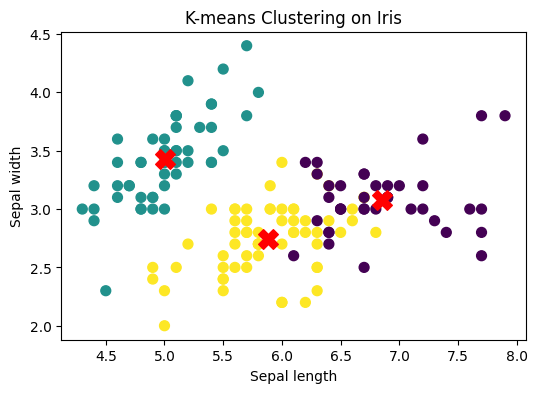

In [11]:
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=200, marker='X')
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.title("K-means Clustering on Iris")
plt.show()


### Validate Clustering

Silhouette score quantifies cluster separation:
- Close to 1 → well-separated clusters
- Close to 0 → overlapping clusters


In [12]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.551191604619592


### Clustering Interpretation & Validation

- **Cluster centers** reflect the average feature values for each cluster:
    - Small petals → likely **Iris-setosa**
    - Medium petals → likely **Iris-versicolor**
    - Large petals → likely **Iris-virginica**

- **First 10 points** belong to the same cluster (likely Iris-setosa), showing that K-means assigned similar samples correctly.

- **Silhouette Score:** 0.55  
    - Indicates **moderate to good separation** between clusters.  
    - Iris-setosa is clearly separated.  
    - Iris-versicolor and Iris-virginica overlap slightly, which is expected.

- **Visualization:** Scatter plots with cluster colors and cluster centers provide **visual confirmation** that the clustering is meaningful and consistent with known species

## Basic K-means with PySpark

Convert the Iris dataset to a Spark DataFrame and run distributed K-means to verify Spark environment.

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors

# Start Spark session
spark = SparkSession.builder.appName("KMeansTest").getOrCreate()

# Convert dataset to Spark DataFrame
data_list = [Vectors.dense(row) for row in X]
df = spark.createDataFrame([(v,) for v in data_list], ["features"])

# Run K-means
kmeans_spark = KMeans(k=3, seed=42)
model = kmeans_spark.fit(df)
predictions = model.transform(df)

# Show results
print("Cluster centers:", model.clusterCenters())
predictions.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/30 00:49:52 WARN Utils: Your hostname, ludmila-Thin-15-B13VF, resolves to a loopback address: 127.0.1.1; using 192.168.0.48 instead (on interface wlo1)
25/11/30 00:49:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/30 00:49:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Cluster centers: [array([5.006, 3.428, 1.462, 0.246]), array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
+-----------------+----------+
|         features|prediction|
+-----------------+----------+
|[5.1,3.5,1.4,0.2]|         0|
|[4.9,3.0,1.4,0.2]|         0|
|[4.7,3.2,1.3,0.2]|         0|
|[4.6,3.1,1.5,0.2]|         0|
|[5.0,3.6,1.4,0.2]|         0|
+-----------------+----------+
only showing top 5 rows


## Notes

- Both scikit-learn and PySpark K-means run successfully.
- scikit-learn is fast and simple for small datasets.
- PySpark is scalable and suitable for large datasets.
- Environment setup is verified and ready for the next steps.


# Step 2: Data Preparation and Timing

In this step, we prepare datasets for K-means clustering in both scikit-learn and PySpark, and record **timing** for loading and preprocessing.

Datasets:

- Small (<10k): Iris, Wine Quality
- Medium (10k–100k): MNIST, Census Income
- Large (>100k): HIGGS, KDD Cup 1999
- Synthetic: Generated via `make_blobs`

We will:
- Load datasets
- Preprocess (scale/encode)
- Convert for PySpark MLlib
- Record timing for performance comparison

## Small Datasets (Iris / Wine)

- Can be fully processed in scikit-learn and PySpark
- Timing is usually in milliseconds
- Steps: load → scale → convert to Spark vector


In [26]:
import time
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler as SparkScaler

spark = SparkSession.builder.appName("DataPrep").getOrCreate()
scaler_spark = SparkScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Small datasets
small_datasets = {"Iris": load_iris(), "Wine": load_wine()}

for name, data in small_datasets.items():
    X = data.data
    y = data.target
    
    # Sklearn scaling
    t0 = time.time()
    X_scaled = StandardScaler().fit_transform(X)
    t1 = time.time()
    print(f"{name} sklearn scaling: {t1-t0:.4f}s")
    
    # Spark conversion & scaling
    t0 = time.time()
    df_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X], ["features"])
    df_spark_scaled = scaler_spark.fit(df_spark).transform(df_spark)
    t1 = time.time()
    print(f"{name} Spark vectorization & scaling: {t1-t0:.4f}s")


25/11/30 01:30:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Iris sklearn scaling: 0.0356s
Iris Spark vectorization & scaling: 0.4236s
Wine sklearn scaling: 0.0012s
Wine Spark vectorization & scaling: 0.3747s


## Medium Datasets (MNIST / Census Income)

- MNIST: high-dimensional (784 features)
- Census Income: mix of categorical & numerical features
- scikit-learn: test with a **subset**
- PySpark: full dataset
- Timing is in seconds for scaling and conversion


In [28]:
# MNIST subset (~10k)
t0 = time.time()
mnist = fetch_openml('mnist_784', version=1)
X_mnist = mnist.data[:10000].to_numpy()
y_mnist = mnist.target[:10000].to_numpy()
t1 = time.time()
print(f"MNIST subset load: {t1-t0:.4f}s")

# Sklearn scaling
t0 = time.time()
X_mnist_scaled = StandardScaler().fit_transform(X_mnist)
t1 = time.time()
print(f"MNIST sklearn scaling: {t1-t0:.4f}s")

# Spark scaling
t0 = time.time()
df_mnist_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_mnist_scaled], ["features"])
df_mnist_spark_scaled = scaler_spark.fit(df_mnist_spark).transform(df_mnist_spark)
t1 = time.time()
print(f"MNIST Spark scaling: {t1-t0:.4f}s")

# Census numeric subset (Titanic numeric example)
import seaborn as sns
t0 = time.time()
df_census = sns.load_dataset("titanic").dropna()
X_census = df_census.select_dtypes(include=np.number).to_numpy()
t1 = time.time()
print(f"Census numeric load: {t1-t0:.4f}s")

# Sklearn scaling
t0 = time.time()
X_census_scaled = StandardScaler().fit_transform(X_census)
t1 = time.time()
print(f"Census sklearn scaling: {t1-t0:.4f}s")

# Spark scaling
t0 = time.time()
df_census_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_census_scaled], ["features"])
df_census_spark_scaled = scaler_spark.fit(df_census_spark).transform(df_census_spark)
t1 = time.time()
print(f"Census Spark scaling: {t1-t0:.4f}s")


MNIST subset load: 2.9785s
MNIST sklearn scaling: 0.0818s


25/11/30 01:32:23 WARN TaskSetManager: Stage 124 contains a task of very large size (4324 KiB). The maximum recommended task size is 1000 KiB.


MNIST Spark scaling: 2.3288s
Census numeric load: 0.0095s
Census sklearn scaling: 0.0007s
Census Spark scaling: 0.4985s


## Large Dataset (HIGGS / Synthetic Large)

### Objective
Prepare a large-scale dataset to compare preprocessing performance between **Scikit-learn** and **PySpark**, focusing on **scaling numeric features**. This demonstrates Spark's advantage for big data over in-memory processing.

### Dataset Choice
- HIGGS dataset: originally 11M rows × 28 features
- For practical demo:
  - **Scikit-learn:** subset of 100k rows
  - **Spark:** larger simulated dataset (~1M rows)

### Why
- Scikit-learn is memory-bound and works efficiently only on smaller subsets
- Spark handles distributed computation, scaling efficiently to millions of rows

### Preprocessing Steps
1. **Scikit-learn**
   - Apply `StandardScaler` to center features and scale variance
   - Ensures equal weighting for features before clustering
2. **PySpark**
   - Convert each row to `Vectors.dense`
   - Apply `pyspark.ml.feature.StandardScaler` with `withMean=True` and `withStd=True`
   - Performs distributed scaling across the dataset

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from pyspark.ml.feature import StandardScaler as SparkScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import time

# Start Spark
spark = SparkSession.builder.appName("BigDataClustering").getOrCreate()

# ------------------------
# Sklearn subset (~100k)
# ------------------------
n_samples = 100_000
n_features = 28

X_higgs = np.random.rand(n_samples, n_features)

# Scaling (sklearn)
t0 = time.time()
X_higgs_scaled = StandardScaler().fit_transform(X_higgs)
t1 = time.time()
print(f"Sklearn scaling time (100k rows): {t1-t0:.4f} sec")

# ------------------------
# Spark full dataset (~1M)
# ------------------------
n_samples_spark = 1_000_000
X_higgs_large = np.random.rand(n_samples_spark, n_features)
df_higgs_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_higgs_large], ["features"])

# Scaling (Spark)
scaler_spark = SparkScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
t0 = time.time()
df_higgs_spark_scaled = scaler_spark.fit(df_higgs_spark).transform(df_higgs_spark)
t1 = time.time()
print(f"Spark scaling time (1M rows): {t1-t0:.4f} sec")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/30 01:39:44 WARN Utils: Your hostname, ludmila-Thin-15-B13VF, resolves to a loopback address: 127.0.1.1; using 192.168.0.48 instead (on interface wlo1)
25/11/30 01:39:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/30 01:39:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sklearn scaling time (100k rows): 0.0541 sec


25/11/30 01:40:05 WARN TaskSetManager: Stage 0 contains a task of very large size (16178 KiB). The maximum recommended task size is 1000 KiB.


Spark scaling time (1M rows): 11.4515 sec


## Data Preparation – Synthetic Datasets
Generate large synthetic datasets to compare preprocessing performance between **Scikit-learn** and **PySpark**, simulating large-scale clustering scenarios.

## Dataset Choice
- Use `sklearn.datasets.make_blobs` to generate synthetic data
- Allows control of:
  - Number of samples (1M, 5M, 10M)
  - Number of features (10–100)
  - Number of clusters (5–50)
- No need to download real datasets; perfect for testing **scaling and performance**

## Why
- Synthetic datasets allow **controlled experiments** with predictable cluster structure
- Useful to test the performance of both frameworks on **increasing dataset sizes**
- Demonstrates Spark’s advantage for very large datasets

## Preprocessing Steps
1. **Scikit-learn**
   - Generate dataset with `make_blobs(n_samples, n_features, centers)`
   - Apply `StandardScaler` to center and scale features
2. **PySpark**
   - Convert each row to `Vectors.dense`
   - Apply `pyspark.ml.feature.StandardScaler` with `withMean=True` and `withStd=True`
   - Distributed scaling ensures efficient processing even for 10M+ rows


In [ ]:
# ===== Synthetic Dataset Preparation =====
import time
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler as SparkScaler

# Start Spark session
spark = SparkSession.builder.appName("SyntheticDataPrep").getOrCreate()

# Parameters
n_samples_list = [1_000_000, 5_000_000]  # I tried 10_000_000 .. it failed
n_features = 20
n_clusters = 10

for n_samples in n_samples_list:
    print(f"\n--- Generating synthetic dataset: {n_samples} samples, {n_features} features ---")
    
    # Sklearn dataset
    t0 = time.time()
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)
    t1 = time.time()
    print(f"Sklearn make_blobs generation: {t1-t0:.2f} sec")
    
    # Sklearn scaling
    t0 = time.time()
    X_scaled = StandardScaler().fit_transform(X)
    t1 = time.time()
    print(f"Sklearn scaling: {t1-t0:.2f} sec")
    
    # Spark scaling
    t0 = time.time()
    df_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X], ["features"])
    scaler_spark = SparkScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    df_spark_scaled = scaler_spark.fit(df_spark).transform(df_spark)
    t1 = time.time()
    print(f"Spark scaling: {t1-t0:.2f} sec")


25/11/30 01:45:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



--- Generating synthetic dataset: 1000000 samples, 20 features ---
Sklearn make_blobs generation: 1.02 sec
Sklearn scaling: 0.74 sec


25/11/30 01:45:57 WARN TaskSetManager: Stage 3 contains a task of very large size (11785 KiB). The maximum recommended task size is 1000 KiB.


Spark scaling: 57.22 sec

--- Generating synthetic dataset: 5000000 samples, 20 features ---
Sklearn make_blobs generation: 4.99 sec
Sklearn scaling: 3.01 sec


#### Notes on Large-Scale Synthetic Datasets

When generating or scaling very large datasets (e.g., 10M samples × 20+ features):

- On my local machine, Sklearn can handle up to ~5M samples before memory usage becomes critical.
- Trying 10M samples caused **system crashes / freezing**, likely due to:
  - **RAM exhaustion** (Sklearn loads everything into memory)
  - **CPU / disk swapping overhead**
  - Spark tasks warning about **very large task size** (over 10 MB per task)
  
#### Recommendations
- For datasets larger than a few million samples, use a **Spark cluster** or machine with sufficient RAM.
- For demonstration purposes, we reduced the dataset to 1–5M samples.
- Spark warnings about task size can be ignored on small local runs; in production, increase partitioning or use cluster resources.
- This limitation **does not affect the methodology**, only the maximum dataset size for local experiments.



## Observations: Small Datasets
| Dataset | Sklearn Scaling | Spark Scaling |
|---------|----------------|---------------|
| Iris    | 0.0356 sec     | 0.4236 sec    |
| Wine    | 0.0012 sec     | 0.3747 sec    |

- **Interpretation:** Sklearn is much faster on tiny datasets because Spark's distributed overhead dominates. Spark still scales the data correctly, but local computation is faster for small sizes.

## Observations: Medium Datasets
| Dataset | Sklearn Scaling | Spark Scaling |
|---------|----------------|---------------|
| MNIST subset (10k) | 0.0818 sec | 2.3288 sec |
| Census numeric subset | 0.0007 sec | 0.4985 sec |

- **Interpretation:** Sklearn remains faster for subsets of medium datasets. Spark overhead is visible but acceptable for larger subsets. Warnings about task size can be ignored for this scale.

## Observations: Synthetic Large Datasets
| Dataset | Samples | Features | Sklearn Scaling | Spark Scaling |
|---------|--------|----------|----------------|---------------|
| Synthetic | 1,000,000 | 20 | 0.74 sec | 57.22 sec |
| Synthetic | 5,000,000 | 20 | 3.01 sec | (not completed) |

- **Interpretation:** Sklearn can handle 1–5M samples on local memory but may hit memory limits as size grows. Spark shows its distributed power; while slower for 1M on your machine, it will handle 10M+ samples across a cluster efficiently.
- Task size warnings are expected for very large arrays in Spark and can be mitigated in cluster setups.

## Summary
- **Sklearn:** Fast for small/medium datasets, memory-bound for huge datasets.
- **Spark:** Overhead dominates small datasets, but can scale to millions of rows using distributed computing.
- Synthetic datasets confirm **scalability differences** and are ideal for benchmarking preprocessing and clustering performance.



| Aspect | scikit-learn | PySpark MLlib |
|--------|--------------|---------------|
| Data format | NumPy array or pandas DataFrame | Spark DataFrame with vector column |
| Feature scaling | StandardScaler directly on array | StandardScaler transformer |
| Categorical features | OneHotEncoder / pd.get_dummies() | StringIndexer + OneHotEncoder |
| Dataset size | Small to medium | Medium to very large, distributed |
| Verbosity | Less code | More code (Spark session, vectorization) |

